# Avocado Data Analysis Notebook
ALT-TAB LABS LLP &copy; 2020 All Rights Reserved


In [1]:
# show files in current directory
import os
os.listdir()

TypeError: required field "type_ignores" missing from Module

In [2]:
# load csvs
import pandas as pd
#MyDataFrame = pd.read_csv('PATH_TO_CSV.csv', index_col='id')
AvoTrain = pd.read_csv('avocado-train.csv', index_col='id')

TypeError: required field "type_ignores" missing from Module

In [3]:
#View the data!
AvoTrain.head()

,DataBatch,Date,TotalVolume,4046,4225,4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,region,AveragePrice
id,,,,,,,,,,,,,
0,7,2016-11-06,183542.31,98949.98,22891.61,95.00,61605.72,43571.99,17499.01,534.72,conventional,NewOrleansMobile,1.49
1,24,2017-07-16,224434.92,42951.31,120360.02,131.85,60991.74,53141.81,3621.04,4228.89,conventional,HarrisburgScranton,1.38
2,51,2015-01-04,3846.69,1500.15,938.35,0.00,1408.19,1071.35,336.84,0.00,organic,Atlanta,1.76
3,22,2015-07-26,91825.07,1679.28,45615.48,741.77,43788.54,43788.54,0.00,0.00,conventional,BuffaloRochester,1.39
4,50,2015-01-11,54644.32,1491.88,33759.12,1325.17,18068.15,12165.94,5902.21,0.00,conventional,Pittsburgh,1.54


In [4]:
#Get a general idea of missing values and data types
"""
We see that Date, type and region have the object dtype. These data are most likely categorical data. 
This can be verified by looking at the above table; they are all strings.

Categorical data can be divided into 3 types:
- Nominal : There is no order to it. E.g. Gender (Male is not more than female, vice versa)
- Ordinal : There is a order to it. E.g. SES (Low, Mid, High)
- Continuous : E.g. Date

In this example, Date is continuous, while type and region are nominal.
"""
AvoTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12774 entries, 0 to 12773
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DataBatch     12774 non-null  int64  
 1   Date          12774 non-null  object 
 2   TotalVolume   12774 non-null  float64
 3   4046          12774 non-null  float64
 4   4225          12774 non-null  float64
 5   4770          12774 non-null  float64
 6   TotalBags     12774 non-null  float64
 7   SmallBags     12774 non-null  float64
 8   LargeBags     12774 non-null  float64
 9   XLargeBags    12774 non-null  float64
 10  type          12774 non-null  object 
 11  region        12774 non-null  object 
 12  AveragePrice  12774 non-null  float64
dtypes: float64(9), int64(1), object(3)
memory usage: 1.4+ MB


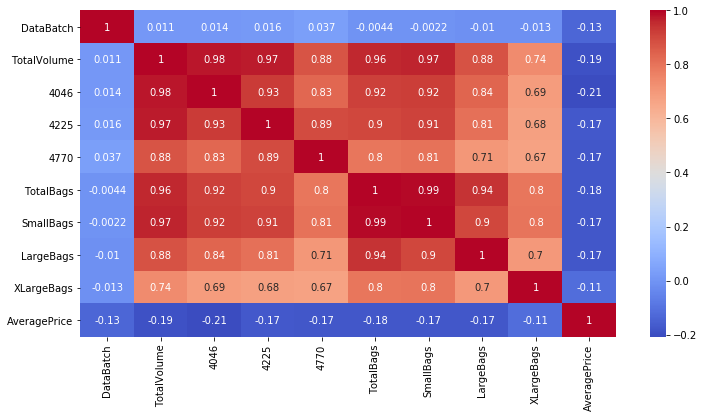

In [5]:
#Get an idea of the correlation
"""
We can see from the plot that most features are not correlated with AveragePrice. 
However, the features are quite strongly correlated with one another.
"""
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.heatmap(AvoTrain.corr(),cmap='coolwarm',annot=True)
plt.draw()

In [6]:
# Clean Data
# Tips and tricks dealing with categorical data: https://www.datacamp.com/community/tutorials/categorical-data
# Type conversion in pandas: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html
"""
We clean the data by doing the following:

1. Drop (or fill) all rows with empty fields.

2. Do some feature engineering on the categorical features:
    - Convert NOMINAL data to dummy values
        - We can also use one-hot encoding. OH encoding is usually better for small data range as 
          it is able to remove any correlation between the different states.
          
          In this case, OH encoding is not recommended as there are 54 unique
          values for region. Doing OH encoding will lead to a great loss of dimensionality.
    - Convert ORDINAL data to ordered values (E.g. {Low : 0, Mid : 1, Hi : 2})
    - Convert CONTINUOUS data to numeric data
    
** For range data, we can split into start and end columns or take the average.
"""
import datetime as dt

# Drops missing values 
AvoTrain = AvoTrain.dropna()

# Convert strings to numbers

# Convert date
AvoTrain.Date = [dt.date.fromisoformat(x).toordinal() for x in AvoTrain.Date]

# We can also convert date like this
# df['Date']=pd.to_datetime(df['Date'])
# df['Month']=df['Date'].apply(lambda x:x.month)
# df['Day']=df['Date'].apply(lambda x:x.day)
# df['Year']=df['Date'].apply(lambda x:x.year)
# df.drop('Date',axis=1,inplace=True)

# Convert type
print(AvoTrain['type'].nunique()) #Number of unique values


AvoTypes = {
    "conventional": 0,
    "organic": 1
}
AvoTrain.type = [AvoTypes[x] for x in AvoTrain.type]

#Convert region
print(AvoTrain['region'].nunique()) #Number of unique values

#Inspect categorical data
AvoRegion = {region: regionid for regionid, region in enumerate(set(AvoTrain.region))}

AvoTrain.region = [AvoRegion[x] for x in AvoTrain.region]

#We can also do this: (Only do this after continuous data and ordinal data have been converted)
# AvoTrain = pd.get_dummies(AvoTrain)

"""
# FOR OH encoding
from sklearn import *

#_valid is predict data.

# Apply one-hot encoder to each column with categorical data
OH_encoder = preprocessing.OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

"""

"""
#FOR RANGED DATA

#START-END METHOD
dummy_df_age = pd.DataFrame({'age': ['0-20', '20-40', '40-60','60-80']})
dummy_df_age['start'], dummy_df_age['end'] = zip(*dummy_df_age['age'].map(lambda x: x.split('-')))

#MEAN METHOD
dummy_df_age = pd.DataFrame({'age': ['0-20', '20-40', '40-60','60-80']})

def split_mean(x):
    split_list = x.split('-')
    mean = (float(split_list[0])+float(split_list[1]))/2
    return mean

dummy_df_age['age_mean'] = dummy_df_age['age'].apply(lambda x: split_mean(x))
"""
pass

# Read more advanced ways to clean data
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
# https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn

2
54


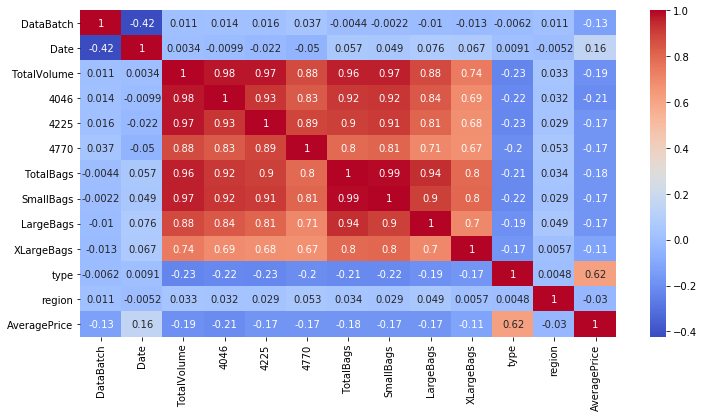

In [7]:
#Get an idea of the correlation again
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.heatmap(AvoTrain.corr(),cmap='coolwarm',annot=True)
plt.draw()

In [8]:
# Select data for learning using above plot after cleaning
features = ["Date", "TotalVolume", "DataBatch", "type", "4046", "4225", "4770", "TotalBags", 
            "SmallBags", "LargeBags", "XLargeBags", "type", "region"]

X = AvoTrain[features] 
y = AvoTrain.AveragePrice

In [9]:
X.head()

,Date,TotalVolume,DataBatch,type,4046,4225,4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,region
id,,,,,,,,,,,,,
0,736274,183542.31,7,0,98949.98,22891.61,95.00,61605.72,43571.99,17499.01,534.72,0,4
1,736526,224434.92,24,0,42951.31,120360.02,131.85,60991.74,53141.81,3621.04,4228.89,0,10
2,735602,3846.69,51,1,1500.15,938.35,0.00,1408.19,1071.35,336.84,0.00,1,12
3,735805,91825.07,22,0,1679.28,45615.48,741.77,43788.54,43788.54,0.00,0.00,0,37
4,735609,54644.32,50,0,1491.88,33759.12,1325.17,18068.15,12165.94,5902.21,0.00,0,28


In [10]:
y.head()

id
0    1.49
1    1.38
2    1.76
3    1.39
4    1.54
Name: AveragePrice, dtype: float64

# Regression Time!
Choosing the best model: https://medium.com/@kefortney/10-machine-learning-flavors-in-sklearn-948206342da2

In [11]:
# Sci Kit Learn! Scientific Computing library for python
from sklearn import *

In [12]:
# Split training into some for training and some for testing
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
"""
70-30 rule
"""
r_state = 2020 #Set to constant for selection of model, else choose None

Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(X, y, test_size=0.3)

print("training split: ", len(Xtrain), "; test split: ", len(Xtest))



training split:  8941 ; test split:  3833


In [13]:
# Pick the regression model we want to use

# Linear Regression
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# model = linear_model.LinearRegression()

# Decision Tree Regression
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
# model = tree.DecisionTreeRegressor(random_state=r_state)

# Random Forest Regression
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
model = ensemble.RandomForestRegressor(random_state=r_state, n_estimators=500) #Test with n_estimators=100 for crude comparison

In [14]:
# Perform regression on the data
model.fit(Xtrain, ytrain) # Xtrain, ytrain  for training X, y after you sure you not overfitting

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=2020, verbose=0, warm_start=False)

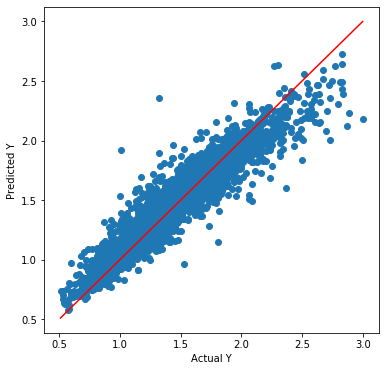

In [15]:
# Plot the model
"""
The graph should look linear.
"""
import numpy as np 

pred = model.predict(Xtest)
plt.figure(figsize=(6,6))
plt.scatter(x=ytest,y=pred)
x = np.linspace(min(min(ytest), min(pred)), max(max(ytest),max(pred)))
plt.plot(x, x, color='red')
plt.xlabel('Actual Y')
plt.ylabel('Predicted Y')
plt.draw()

In [16]:
#Analyse the models to choose the best one.
"""
Lower the RMSE, the better.
"""
import numpy as np
print('MAE:', metrics.mean_absolute_error(ytest, pred))
print('MSE:', metrics.mean_squared_error(ytest, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(ytest, pred)))

#Simple analytics
# model.score(Xtest, ytest)

MAE: 0.09183755283068097
MSE: 0.01686725412940255
RMSE: 0.12987399327580001


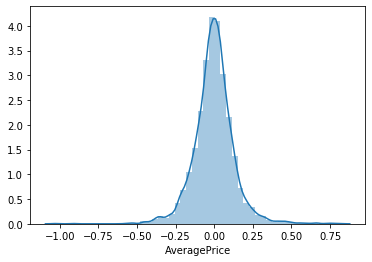

In [17]:
# Distribution plot
"""
The residuals should look normally distributed for a good model.
"""
sns.distplot((ytest-pred),bins=50)
plt.draw()

# Predict for Testing data

In [18]:
# Load Data
AvoTest = pd.read_csv('avocado-test.csv', index_col='id')
AvoTest.head()

,DataBatch,Date,TotalVolume,4046,4225,4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,region
id,,,,,,,,,,,,
0,21,2016-07-31,28969.34,80.77,27361.91,0.00,1526.66,1526.66,0.00,0.00,organic,Chicago
1,19,2017-08-20,322962.89,5632.85,242365.82,2441.56,72522.66,22942.48,46083.51,3496.67,conventional,NorthernNewEngland
2,49,2017-01-22,155334.45,3657.79,74068.65,0.00,77608.01,27302.29,50305.72,0.00,organic,GreatLakes
3,12,2015-10-04,10231.74,341.89,8519.00,0.00,1370.85,303.33,1067.52,0.00,organic,CincinnatiDayton
4,10,2015-10-18,10652.02,6905.95,39.52,0.00,3706.55,3706.55,0.00,0.00,organic,Houston


In [19]:
# Clean Data

# Drops missing values 
AvoTest = AvoTest.dropna()

# Convert strings to numbers
AvoTest.Date = [dt.date.fromisoformat(x).toordinal() for x in AvoTest.Date]

AvoTest.type = [AvoTypes[x] for x in AvoTest.type]

AvoTest.region = [AvoRegion[x] for x in AvoTest.region]

# Read more advanced ways to clean data
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
# https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn

In [20]:
# Select features
XforPredictions = AvoTest[features]
XforPredictions.head()

,Date,TotalVolume,DataBatch,type,4046,4225,4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,region
id,,,,,,,,,,,,,
0,736176,28969.34,21,1,80.77,27361.91,0.00,1526.66,1526.66,0.00,0.00,1,48
1,736561,322962.89,19,0,5632.85,242365.82,2441.56,72522.66,22942.48,46083.51,3496.67,0,5
2,736351,155334.45,49,1,3657.79,74068.65,0.00,77608.01,27302.29,50305.72,0.00,1,23
3,735875,10231.74,12,1,341.89,8519.00,0.00,1370.85,303.33,1067.52,0.00,1,2
4,735889,10652.02,10,1,6905.95,39.52,0.00,3706.55,3706.55,0.00,0.00,1,42


In [21]:
# Make Predictions!
yPredictions = model.predict(XforPredictions)
print("Predictions:", yPredictions)

Predictions: [1.83882 1.60462 1.2566  ... 1.45532 1.80802 1.59026]


In [22]:
# Save to CSV File!
output = pd.DataFrame({'id': XforPredictions.index, 'AveragePrice': yPredictions})
output['AveragePrice'] = [f"{x:.2f}" for x in output["AveragePrice"]] #Format to same number of d.p/ s.f. as train data
output.to_csv('avocado-submission.csv', index=False)
print(output)

        id AveragePrice
0        0         1.84
1        1         1.60
2        2         1.26
3        3         1.55
4        4         1.44
...    ...          ...
5470  5470         1.80
5471  5471         1.44
5472  5472         1.46
5473  5473         1.81
5474  5474         1.59

[5475 rows x 2 columns]


# Upload for grading

In [23]:
# Download CTFSG Grader Libraries
import urllib.request, os
urllib.request.urlretrieve('https://raw.githubusercontent.com/alttablabs/ctfsg-utils/master/pyctfsglib.py', './pyctfsglib.py')
print('Downloaded pyctfsglib.py:', 'pyctfsglib.py' in os.listdir())

Downloaded pyctfsglib.py: True


In [24]:
# Connect to graders
import pyctfsglib as ctfsg
import random

USER_TOKEN = "???" # You need to fill this up
GRADER_URL = random.choice([
"http://challenges.csdc20t.ctf.sg:30001/", "http://challenges.csdc20t.ctf.sg:30002/"
])

grader = ctfsg.DSGraderClient(GRADER_URL, USER_TOKEN)

DSGraderClient: Successfully Connected!
[SERVER] MOTD: CHECK your USER_TOKEN and GRADER_URL HTTP address! I'm AVOCADO_PRICE GRADER_be64ff40591f


In [25]:
x = grader.submitFile('avocado-submission.csv')

ProofOfWork Challenge =>  ('CTFSGRB6f934dcfcfde854ebe7781660fdf884f', 22)
ProofOfWork Answer Found! =>  3090590


In [26]:
#Compute correctness
MAX_SCORE = 500
x=eval(x)
x['multiplier'] * MAX_SCORE

448.75